# Import packages

In [2]:
import tensorflow as tf
import numpy as np
import datetime
import time
import random
import inflect
import string
import pandas as pd
import pickle
import h5py
import itertools
from nltk.corpus import wordnet as wn
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
random.seed(10)

# Generating data

This first part is about getting the data to train the neural network. A part of the data is generated (dates, strings), while the other part is extracted from databases (locations, company names, physical goods and other). These databases are available to the public, but are not included in the repository.
However, the repository contains some .txt files with the words extracted from such databases.

In [3]:
# this corresponds to the size of the smaller dataset available. 
# It will be used to balance the training set for each class
size_dataset = 2639

## Generate random dates

In [4]:
from random import randrange
from datetime import timedelta

# generate a random date
def random_date(start, end):

    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    date = start + timedelta(seconds=random_second)
    
    return int(date.strftime("%Y")), int(date.strftime("%m")), int(date.strftime("%d"))

In [5]:
# generate random date format
p = inflect.engine()

def random_format():
    
    # choose random date format
    char_list = ["/", "-", " "] # spacer
    d = '%d' 
    m = random.choice(['%b','%B','%m']) # month format
    y = random.choice(['%y','%Y']) # year format
    c = random.choice(char_list)
    
    # day first or month first
    ordinal = random.choice([True,False])

    format0 =  m + c + d + c + y # month first
    format1 = d + c + m + c + y # day first
    format_list = [format0, format1]
    f = random.choice(format_list)
    
    # generate random dates between year 1800 and 2020
    d1 = datetime.datetime.strptime('1/1/1800', '%m/%d/%Y')
    d2 = datetime.datetime.strptime('10/5/2020', '%m/%d/%Y')
    year, month, day = random_date(d1, d2)
    

    x = datetime.datetime(year, month, day)
    
    # if month is not in numeric format, add -st, -nd, -rd or -th to day
    if m != "%m":
        format2 = x.strftime(m) + c + p.ordinal(x.strftime(d).lstrip("0")) + c + x.strftime(y)
        format3 = p.ordinal(x.strftime(d).lstrip("0")) + c + x.strftime(m) + c + x.strftime(y)
        
        x = random.choice([x.strftime(f), format2, format3] )
        
    else:
        x = x.strftime(f)
        
    return x

In [6]:
# a small set of random dates
for i in range(0,20):
    date = random_format()
    print(date)

01-20-28
November 12th 1870
Apr 27 93
15-09-1835
Apr 17 1998
March/27th/1818
07/05/1859
Dec 29 1931
Sep-16-08
Jun 22 1951
February/2nd/32
May/5th/1836
26/Aug/44
Nov-18th-10
January-30th-73
10/10/1891
12-October-02
09/08/1918
9th/September/20
July/29th/1925


In [7]:
# generate random dates list
n_dates = size_dataset#5000
dates_list = list()
[dates_list.append(random_format()) for d in range(n_dates)];

## Generate random strings

In [8]:
# generate random strings, by mixing letters, punctuation and digits
def generate_random_string():
    
    characters = random.choice([string.ascii_letters,
                                #string.punctuation, # punctuation only looks too random
                                string.digits,
                                string.ascii_letters + string.punctuation,
                                string.ascii_letters + string.digits,
                                string.punctuation + string.digits,
                                string.ascii_letters + string.punctuation + string.digits])
    
    # length will be between 1 and 20 characters
    rand_string = "".join(random.choice(characters) for x in range(random.randint(1, 20)))
    return rand_string

In [9]:
# a small set of random strings
for i in range(0,15):
    random_string = generate_random_string()
    print(random_string)

swfvsJSzI
sqQC
VwXqa
3;7{HZQ9am4"p
TwxzHjDvWcCav
}
bTXlNsDocXSD
58619977098
4669
knZMKviWqV
974891419847569475
#.nszG
,)$%
59832030553924432
||9&(4_*8`^\*27]+


In [10]:
# generate random strings list
n_strings = size_dataset#5000
strings_list = list()
[strings_list.append(generate_random_string()) for d in range(n_strings)];

## Get location data

In [11]:
# delete redundant strings in a list
def make_unique_list(l):
    unique_list = list()
    [unique_list.append(x) for x in l if x not in unique_list]
    return unique_list

In [13]:
# generate location dataset
df_loc = pd.read_csv('world-cities.csv').dropna()
df_numpy = df_loc.to_numpy()
locations_list = df_numpy[:,0:3].flatten() 
locations_list = make_unique_list(locations_list)
locations_list = random.sample(locations_list, size_dataset)

In [14]:
# a small set of places
locations_list[0:15]

['Aburi',
 'Golestān',
 'Tlaxcala de Xicohtencatl',
 'Anshun',
 'Loboc',
 'Albert Lea',
 'Lar',
 'Fairborn',
 'Shchukino',
 'Bugiri',
 'Cork',
 'Russas',
 'Ayvalık',
 'Heppenheim an der Bergstrasse',
 'Humanes de Madrid']

## Get companies names data

In [140]:
# generate companies names dataset
df_list = list()
for i in range(6):
    name = 'BasicCompanyData-2020-05-01-part' + str(i+1) + '_6.csv'
    df = pd.read_csv(name, low_memory=False)
    df_list.append(df['CompanyName'])

# save only the part with the names
all_df = pd.concat(df_list)

In [279]:
# Take small sample of the dataset
df_reduced = all_df.sample(size_dataset)
print(len(df_reduced))

2639


In [280]:
# first letter of each word uppercase and convert to list
df_capitalise = df_reduced.str.title()
companies_list = df_capitalise.to_list()

In [281]:
# a small set of companies names
companies_list[0:15]

['Merchant Place, Northallerton Management Limited',
 'On Location Hire Limited',
 'St Ronans Property Management Company Limited',
 'Mach Global One Limited',
 'C & R James Limited',
 'Dei Holdings Ltd',
 'Ajc Consults Limited',
 'Mdavis&Prospectconsutants Limited',
 'Tmlpse Ltd',
 'V8 Specialists Ltd',
 'Kl De Wit Ltd',
 'Willoughby Court Rtm Company Limited',
 'Nick Inc Ltd',
 'Kam Cars Worcester Ltd',
 'Everwood Estates Limited']

## Get physical goods data

In [3]:
# use WordNet to create set of nouns, verbs, adjectives and adverbs
nouns = {x.name().split('.', 1)[0] for x in wn.all_synsets('n')}
verbs = {x.name().split('.', 1)[0] for x in wn.all_synsets('v')}
adjectives = {x.name().split('.', 1)[0] for x in wn.all_synsets('a')}
adverbs = {x.name().split('.', 1)[0] for x in wn.all_synsets('r')}

In [ ]:
# convert lists of amazon reviews into dataframes, but keep only the 'product_title' column
df_tool = pd.read_table('amazon_reviews_us_Tools_v1_00.tsv',error_bad_lines=False)['product_title'].dropna();
df_home = pd.read_table('amazon_reviews_us_Home_v1_00.tsv',error_bad_lines=False)['product_title'].dropna();
df_electronics= pd.read_table('amazon_reviews_us_Electronics_v1_00.tsv',error_bad_lines=False)['product_title'].dropna();
df_furniture= pd.read_table('amazon_reviews_us_Furniture_v1_00.tsv',error_bad_lines=False)['product_title'].dropna();
df_sports= pd.read_table('amazon_reviews_us_Sports_v1_00.tsv',error_bad_lines=False)['product_title'].dropna();
df_grocery= pd.read_table('amazon_reviews_us_Grocery_v1_00.tsv',error_bad_lines=False)['product_title'].dropna();

In [6]:
# define function to fill a list of words in the right format
def get_wordstlist(df_tool):
    
    # retain product_title and convert into list
    df_tool_list = df_tool.to_list()
    
    # convert strings of descriptions into a single very long text string
    df_tool_list = ' '.join(df_tool_list)
    
    # separate the text string into single words
    join_tool_list = df_tool_list.split(' ')

    # keep strings containing letters only, are nouns, non-adjectives, non-verbs, non-adverbs
    #and are longer than two characters, then convert to title format
    word_tool_list = []
    [word_tool_list.append(word.lower()) for word in join_tool_list if word.isalpha() 
     and word.lower() in nouns and word.lower() not in adjectives and word.lower() not in verbs
     and word.lower not in adverbs and len(word)>2]
    
    # delete repetitions
    word_tool_list = make_unique_list(word_tool_list)
    
    return word_tool_list

In [11]:
# keep only similar words (in this case, each word has to be some kind of tool)
# this method seems to be relatively safe, provided that similarity_thr is high enough
def keep_similar(words, similar_string, similarity_thr):
    similar_words=[]
    
    # the choice of 'similar_string' is very critical. It is supposed to represent
    # the concept of 'physical good' for each of the amazon databases
    #w2 = wn.synset('tool.n.01') 
    w2 = wn.synset(similar_string + '.n.01') 

    # similarity_thr is a critical parameter
    [similar_words.append(word) for word in words if wn.synset(word + '.n.01').wup_similarity(w2)>=similarity_thr ]
    return similar_words

In [18]:
# remove redundant words from lists
words_tool = get_wordstlist(df_tool)
words_home = get_wordstlist(df_home)
words_furniture = get_wordstlist(df_furniture)
words_electronics = get_wordstlist(df_electronics)
words_sports = get_wordstlist(df_sports)
words_grocery = get_wordstlist(df_grocery)

In [98]:
# set similarity_thr: 0.61 is already a strict threshold. Imposing a slightly higher threshold 
# significantly reduces the size of the 'physical goods' dataset
similarity_thr = 0.61

# keep only those words whose concept is similar to the word 'tool'
similar_tool = keep_similar(words_tool, 'tool', similarity_thr)
similar_home = keep_similar(words_home, 'tool', similarity_thr)
similar_electronics = keep_similar(words_electronics, 'resistor', similarity_thr)
similar_furniture = keep_similar(words_furniture, 'couch', similarity_thr)
similar_sports = keep_similar(words_sports, 'ball', similarity_thr)
similar_grocery = keep_similar(words_home, 'food', similarity_thr)

In [100]:
print(len(similar_tool), len(similar_home), len(similar_grocery), len(similar_sports), len(similar_furniture),
     len(similar_electronics))

800 1133 282 627 206 495


In [101]:
# combine tools and home lists, then delete shared items
similar_all = similar_tool + similar_home + similar_electronics + similar_furniture +\
            similar_sports + similar_grocery
similar_all = make_unique_list(similar_all)

In [102]:
# augment size of dataset by including synonims
def get_synonims(word_list, synonym_similarity_thr):
    syn = list()
    
    for word in word_list:
        for synset in wn.synsets(word):
            
            # append the original word
            syn.append(word)
            
            # try if there is no error 
            try:
                similarity = synset.wup_similarity(wn.synset(word + '.n.01'))
                if similarity == synonym_similarity_thr:
                
                    for lemma in synset.lemmas():
                        # append the suitable synonyms
                        syn.append(lemma.name().lower().replace('_', ' '))
            
            except:
                continue
            
    # delete redundant synonims
    syn = make_unique_list(syn)
    return syn

In [103]:
# a lot of synonims seem to be unrlelated to the input word. We impose a very strict similarity threshold
synonym_similarity_thr = 1.0
goods_list = get_synonims(similar_all, synonym_similarity_thr)
print(len(similar_all), len(goods_list))

1622 2639


The physical goods dataset seems to have a much smaller size compared to the others. Hower, it is crucial to have a good quality set of words, which we are really sure to represent the 'physical goods' class.

In [238]:
# a small set of physical goods names
goods_list[0:20]

['workbench',
 'work bench',
 'bench',
 'pegboard',
 'pliers',
 'pair of pliers',
 'plyers',
 'kit',
 'flashlight',
 'torch',
 'holder',
 'lamp',
 'hydrometer',
 'gravimeter',
 'lens',
 'lense',
 'lens system',
 'weapon',
 'arm',
 'weapon system']

## Get 'other' data

In [282]:
# create a list of every list generated except for 'others'
all_words_without_others = dates_list + locations_list + strings_list + companies_list + goods_list

# by applying lower case to every word, we avoid keeping doubles with lower/upper cases 
all_words_without_others_lower = [x.lower() for x in all_words_without_others]

In [283]:
# generate 'Other' dataset. Let's stick to just nouns for convenience
others_list = list()

# creat list of wordnet words
wordnet_words = nouns.union(verbs).union(adjectives).union(adverbs).union(nouns)
wordnet_words.remove('')
#wordnet_words = random.shuffle(list(all_words))
#wordnet_words = filter(lambda x: x is not None, wordnet_words)
#print(wordnet_words[0])

for word in wordnet_words:
    #print(word)
    word = word.capitalize().replace('_', ' ')
    
    # we want no elements in common with the other sets of words we generated earlier. 
    # Also, we want no upper/lower case doubles
    if word.lower() not in all_words_without_others_lower:
        others_list.append(word)
        if len(others_list) >= size_dataset:
            break

In [284]:
# a small set of other strings names
others_list[0:15]

['Wild spinach',
 'Nonviolent',
 'Rejoin',
 'Genus aerides',
 'Manifest',
 'Altogether',
 'Top-secret',
 'Fringed pink',
 'Digit',
 'Boo',
 'Apogamic',
 'Couchant',
 'Headliner',
 'Inclusion body',
 'Coccidae']

In [46]:
# save generated lists
#with open("others_list.txt", "wb") as fp:
#    pickle.dump(others_list, fp)
#with open("locations_list.txt", "wb") as fp:
#    pickle.dump(locations_list, fp)
#with open("goods_list.txt", "wb") as fp:
#    pickle.dump(goods_list, fp)
#with open("companies_list.txt", "wb") as fp:
#    pickle.dump(companies_list, fp)
#with open("strings_list.txt", "wb") as fp:
#    pickle.dump(strings_list, fp)
#with open("dates_list.txt", "wb") as fp:
#    pickle.dump(dates_list, fp)

# Generating datasets

In this section, a dataset containing the input data and the target labels is generated. For the purpose of the task, the previous section can be ignored, the list of words can be loaded in the next cell.

In [3]:
# load txt lists (available in the repo)
with open("others_list.txt", "rb") as fp:
    others_list = pickle.load(fp)
with open("dates_list.txt", "rb") as fp:
    dates_list = pickle.load(fp)
with open("strings_list.txt", "rb") as fp:
    strings_list = pickle.load(fp)
with open("locations_list.txt", "rb") as fp:
    locations_list = pickle.load(fp)
with open("goods_list.txt", "rb") as fp:
    goods_list = pickle.load(fp)
with open("companies_list.txt", "rb") as fp:
    companies_list = pickle.load(fp)

In [7]:
# create a list of every list generated
all_words = dates_list + locations_list + strings_list + companies_list + goods_list + others_list

In [33]:
# show small random sample of words
random.sample(all_words,20)

['Stand oil',
 'Murrysville',
 'timber',
 'Attack',
 '07/27/94',
 '8th-December-1821',
 'C C Decorating Ltd',
 'Chalim Limited',
 'vVBbeTsozHcf',
 '28/05/1991',
 'Hattiesburg',
 'Good-temperedness',
 'Scar tissue',
 'coal scuttle',
 'D',
 '19th Nov 31',
 '1631449367875997236',
 'Cleaners',
 '25th-November-1984',
 'Broad Reach Limited']

In [8]:
all_lists = [dates_list, locations_list, strings_list, companies_list, goods_list, others_list]

In [9]:
# generate target labels
def generate_labels(item_list):
    index = 0

    for l in item_list:
        a = np.zeros([len(l)]) + index
        
        if index == 0:
            labels = np.hstack((a))
        else:
            labels = np.hstack((labels, a))
        
        index += 1
        
    # convert labels to categorical format
    cat_labels = tf.keras.utils.to_categorical(labels)
    return cat_labels

cat_labels = generate_labels(all_lists)

In [10]:
# generate dataset object
def generate_dataset(data, cat_labels, batch_size):

    dataset = tf.data.Dataset.from_tensor_slices((data, cat_labels))

    return dataset

full_dataset = generate_dataset(np.asarray(all_words), cat_labels, 32)

In [11]:
# split into train and test datasets
def split_dataset(full_dataset):
    dataset_size = len(list(full_dataset))
    train_size = int(0.8 * dataset_size)
    test_size = int(0.2 * dataset_size)

    full_dataset = full_dataset.shuffle(buffer_size=dataset_size)
    train_dataset = full_dataset.take(train_size)
    test_dataset = full_dataset.skip(train_size)
    test_dataset = test_dataset.take(test_size)
    
    return train_dataset, test_dataset
    
train_dataset, test_dataset = split_dataset(full_dataset)

In [12]:
# in case data is loaded from dataset, this can quickly retrieve data in numpy. 
# This needs to be done in order to tokenize data
def retrieve_data(dataset):
    dataset_size = len(list(dataset))
    x = list()
    y = list()
    
    # loop over dataset
    for data, labels in dataset:
        
        # convert tensors into numpy, then append to list
        x.append(data.numpy())
        y.append(labels.numpy())
    
    return np.asarray(x), np.asarray(y)

x_train, y_train = retrieve_data(train_dataset)
x_test, y_test = retrieve_data(test_dataset)

In [13]:
# check train and test shapes
print(x_train.shape, x_test.shape)

(12667,) (3166,)


# Tokenization

In [14]:
# create and fit tokenizer at character level
tokenizer = Tokenizer(char_level=True)

# tokenizer is fit only on training data
tokenizer.fit_on_texts(x_train)

In [15]:
# apply tokenizer to dataset
x_train_token = tokenizer.texts_to_sequences(x_train)
x_test_token = tokenizer.texts_to_sequences(x_test)

In [16]:
# zero padding adds zeros to even strings of different lengths (they will be masked by the embedding layer)
x_train_pad = tf.keras.preprocessing.sequence.pad_sequences(x_train_token, padding='post')
x_test_pad = tf.keras.preprocessing.sequence.pad_sequences(x_test_token, padding='post')

# Setup and training deep learning architecture

This section contains the actual training of the deep neural network.

In [17]:
# maximum token value
max_index_value = len(tokenizer.word_index)

In [18]:
# a recurrent neural network seems to be the ideal architecture to capture the data structure. 
# A bi-directional layer is used to run through the tokenized characters strings back and forth

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(max_index_value+1, 16, mask_zero=True), # ignore padding zeros
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, return_sequences=True), merge_mode='concat'), # output is 16
    tf.keras.layers.GRU(8),
    tf.keras.layers.Dense(6, activation='softmax') # 6 is the number of classes
])

In [19]:
# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.categorical_crossentropy, 
              metrics=[tf.keras.metrics.categorical_accuracy])

In [20]:
# chekpoints: only save model with best validation accuracy
checkpoint_best_path = 'models/model_best.h5'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path,
                                  monitor='val_categorical_accuracy',
                                 save_best_only=True)

In [21]:
# fit model and save history
history = model.fit(x_train_pad, 
                    y_train, 
                    epochs=10, 
                    batch_size=32, 
                    validation_split=0.1,
                    callbacks=[checkpoint_best])

Train on 11400 samples, validate on 1267 samples
Epoch 1/10
11400/11400 [==============================] - 35s 3ms/sample - loss: 1.0767 - categorical_accuracy: 0.5745 - val_loss: 0.7096 - val_categorical_accuracy: 0.7064
Epoch 2/10
11400/11400 [==============================] - 28s 2ms/sample - loss: 0.6575 - categorical_accuracy: 0.7104 - val_loss: 0.6174 - val_categorical_accuracy: 0.7364
Epoch 3/10
11400/11400 [==============================] - 29s 3ms/sample - loss: 0.6025 - categorical_accuracy: 0.7374 - val_loss: 0.5764 - val_categorical_accuracy: 0.7482
Epoch 4/10
11400/11400 [==============================] - 28s 2ms/sample - loss: 0.5697 - categorical_accuracy: 0.7505 - val_loss: 0.5438 - val_categorical_accuracy: 0.7680
Epoch 5/10
11400/11400 [==============================] - 27s 2ms/sample - loss: 0.5438 - categorical_accuracy: 0.7590 - val_loss: 0.5176 - val_categorical_accuracy: 0.7822
Epoch 6/10
11400/11400 [==============================] - 27s 2ms/sample - loss: 0.525

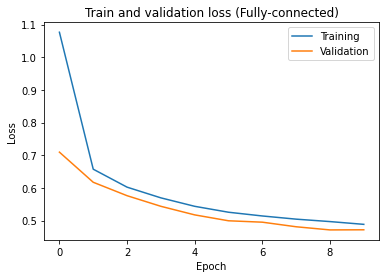

In [22]:
# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train and validation loss (Fully-connected)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

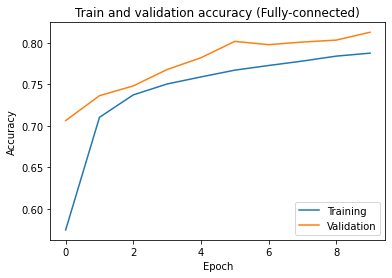

In [23]:
# plot accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Train and validation accuracy (Fully-connected)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

Variations in the validation loss and accuracy are small enough after 6 epochs. There is no need to further increase the number of epochs. 

# Neural network evaluation

There is no need to re-train the model, it can be loaded from the cell below.

In [24]:
# load best RNN
best_model = tf.keras.models.load_model(checkpoint_best_path)

In [25]:
# evaluate the RNN performance
results = best_model.evaluate(x_test_pad,y_test)
predictions = best_model.predict(x_test_pad)

3166/3166 [==============================] - 2s 547us/sample - loss: 0.4995 - categorical_accuracy: 0.7925


In [26]:
# transofrm numpy matrices into df columns
def flat_array(output):
    df_list = list()
    [df_list.append(output[index]) for index in range(len(output))]
    return df_list

df_ytest = flat_array(y_test)
df_predictions = flat_array(predictions)

# round predictions values for visualization purposes
df_predictions_round = list(np.around(np.array(df_predictions),2))

In [27]:
# convert ground-truth labels from categorical to actual string
name_labels = ['Date', 'Location', 'Random string', 'Company names', 'Physical goods', 'Other']
labels_strings_list = list()
[labels_strings_list.append(list(itertools.compress(name_labels, line))) for line in y_test];

In [87]:
# create prediction dataframe
data = {'Strings': pd.Series(x_test).str.decode('utf-8'), 'Ground-truths (string)': labels_strings_list, \
        'Ground-truths': df_ytest ,'Predictions': df_predictions_round}
df = pd.DataFrame (data, columns = ['Strings', 'Ground-truths (string)', 'Ground-truths', 'Predictions'])


In [88]:
df

,Strings,Ground-truths (string),Ground-truths,Predictions
0,repast,[Physical goods],"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[0.0, 0.11, 0.0, 0.01, 0.49, 0.4]"
1,kit,[Physical goods],"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[0.0, 0.14, 0.04, 0.0, 0.62, 0.2]"
2,F,[Random string],"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0.02, 0.07, 0.81, 0.01, 0.07, 0.03]"
3,HhsTbQDdC,[Random string],"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
4,Inhalation anesthetic,[Other],"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.11, 0.0, 0.03, 0.16, 0.7]"
...,...,...,...,...
3161,14th Jan 1996,[Date],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3162,Climbing hempweed,[Other],"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.99, 0.0, 0.0]"
3163,Cat box,[Other],"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.11, 0.01, 0.0, 0.54, 0.34]"
3164,piece,[Physical goods],"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[0.0, 0.11, 0.0, 0.01, 0.54, 0.34]"


In [89]:
# save df to .csv
df.to_csv('prediction_nlp.csv')

# Final remarks

In this test, the idea was providing the network with a balanced amount of data. In other words, each dataset has exactly the same size, corresponding to the size of the smaller of the datasets available (physical goods).

While it is possible to virtually generate an infinite amount of dates and random strings, the other datasets are potentially limited by the size of the database available. However, the databases available for locations, company names and others are very large, while the physical goods dataset is much smaller in comparison. In fact, while it is possible to generate an infinite amount of company names, there is a limited number of physical goods in any English vocabulary.

The idea here is that, by checking the final accuracy, we can see that the neural network is very accurate in detecting dates, random strings and company names, which means that the amount of data used for these classes is sufficient to get a good classification accuracy.

On the other side, the network tends to struggle when classifying locations and physical goods.
An informal test, suggests that using the whole locations dataset instead of a fraction, only leads to a minimal improvement in the validation accuracy.